# Trabalho de Redes Complexas



**ALUNA:**: Ana Carolina Wagner Gouveia de Barros


**PROFESSOR**: Moacyr Silva


**Mestrado em Modelagem Matemática - EMAp|FGV - 2019.2**

In [672]:
# Bibliotecas importadas
import networkx as nx
import random as rnd
rnd.seed()
import numpy as np
import csv
import pickle
import itertools

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

___

## I. Geração de Redes
___

### EXERCÍCO 1:

Construa um programa que gere uma rede a partir de uma distribuição dada – “configuration model” ou modelo de pareamento. Para simplificar, pode permitir *autoloops* e arestas repetidas.

**Entrada:** número de vértices $N$, grau de cada nó.

**Saída:** lista de arestas.

___
O **modelo de configuração** cria uma rede com uma sequência de graus predefinida (pode ser qualquer uma). O algoritmo começa a partir de uma distribuição de grau inicialmente especificada $p_k$ (fração de vértices na rede que tem grau $k$), em que atribuímos a cada nó $i$ um grau $k_i$ de acordo com uma certa distribuição. Vale ressaltar que o grau total da rede deve ser par, caso contrário teremos nós desemparelhados. 

*Fonte*: http://networksciencebook.com/chapter/4#generating-networks

<img src="Figuras/configurationmodel_barabasi.jpg" alt="drawing" width="300"/>


* Começamos selecionando um par de vértices aleatoriamente e ligamos eles. 


* A cada etapa que selcionamos, diminuímos duas unidades da quantidade de grau total da rede e repetimos esse processo até que não tenha mais nenhum grau remanescente.

Aplicando repetidamente esse procedimento na mesma sequência de graus, podemos gerar redes diferentes com o mesmo $p_k$, algumas possuem ciclos, auto-loops ou até mesmo multiligações. 

**Obs.:** Este modelo, por ter um caráter inerentemente aleatório, ajuda a calcular analiticamente numerosas medidas de rede.
___

A função `configurationModel` recebe como **parâmetros de entrada** o número de vértices $N$ e um dicíonário *degree_dist*, formado pelos vértices e seus respectivos graus, e gera como **saída** uma lista de arestas, *edges*, com todas as ligações formadas a partir do pareamento.

In [2]:
def configurationModel(N,degree_dist):
    
    edges = []
    nodes = list(range(1,N+1))
    
    degrees = list(degree_dist.values())
    degree_total = sum(list(degree_dist.values()))
    
    while degree_total > 0:
        node_i = rnd.choice(nodes)
        degree_dist[node_i] -= 1
        if degree_dist[node_i] == 0:
            nodes.remove(node_i)
         
        node_j = rnd.choice(nodes)
        degree_dist[node_j] -= 1
        if degree_dist[node_j] == 0:
            nodes.remove(node_j)
 
        degree_total = degree_total - 2
 
        edges.append([node_i, node_j])
 
    return edges

___
### EXERCÍCIO 2:

Gere redes livres de escala com $1.000$ vértices a partir do modelo de pareamento com as seguintes combinações de parâmetros: $\alpha = 2.5$ e $\left \langle k \right \rangle = 1$, $\left \langle k \right \rangle=2$ e $\left \langle k \right \rangle=10$.


___

Com o algoritmo criado no **Exercício 1**, vamos usar a **distribuição de pareto** para gerar a distribuição dos graus. 

$$F(x)=1-\left(\frac{x_{m}}{x}\right)^{\alpha+1}$$

Para cada nó $i$ é gerado um número aleatório $y$ e calculamos $F^{-1}(x)$, dada por

$$F^{-1}(x)=x_{m}(1-y)^{-1/\alpha+1}$$

O valor do grau mínimo $x_m$ é calculado em função do grau médio $\left\langle k\right\rangle$ , em que $x_{m}=\left\langle k\right\rangle \left(\frac{\alpha}{\alpha+1}\right)$. 

A função `degreeDistributionPareto`  recebe como **parâmetros de entrada** o número de vértices $N$, o expoente $\alpha$ e o grau médio  $\left\langle k\right\rangle$ e gera como **saída** um dicionário com os vértices e seus respectivos graus de acordo com a distribuição prede􏰀finida. 



In [3]:
def degreeDistributionPareto(N, alpha, k):
    
    nodes = []
    degree_total = 0
 
    # Grau Minimo
    xm = k * (alpha / (alpha + 1))
    
    for i in range(1, N + 1):
        degree = 0
        while degree == 0: 
            y = rnd.random()
            inversa = xm * ((1 - y) ** (1/ (-alpha + 1))) 
            degree = int(inversa)
 
        degree_total = degree_total + degree
        nodes.append([i, degree])
        
    if (degree_total % 2) != 0:
        nodes[0][1] = nodes[0][1] + 1
 
    nodes_dict = {node[0]: (node[1]) for node in nodes}
    return nodes_dict

Vamos usar o algoritmo criado, `degreeDistributionPareto`, para gerar as redes a partir da distribuição de pareto.

In [4]:
# Parâmetros do modelo
N=1000
alpha=2.5

In [5]:
G1 = degreeDistributionPareto(N, alpha, 1)
G2 = degreeDistributionPareto(N, alpha, 2)
G3 = degreeDistributionPareto(N, alpha, 10)

Agora, vamos usar o algoritmo `configurationModel` para gerar **redes livres de escala** a partir do modelo de paramento, em que o grau $k$ de cada nó $i$ é extraído a partir de uma **distribuição de pareto**. Com $N = 1.000$ geramos três redes usando esse algoritmo. 

In [6]:
#SF1 = configurationModel(N, G1)
#SF2 = configurationModel(N, G2)
#SF3 = configurationModel(N, G3)

#pickle.dump([SF1,SF2,SF3], open("Redes/Pareamento_SF.p", "wb"))
[SF1,SF2,SF3] = pickle.load(open("Redes/Pareamento_SF.p", "rb" ))

In [7]:
def write_csv(G,name):
    length = len(G)
    with open("Redes/Pareamento_%s.csv" %(name), "w", newline="") as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Source', 'Target'])
        for i in range(length):
            csv_writer.writerow(G[i])

#write_csv(SF1,"SF1")
#write_csv(SF2,"SF2")
#write_csv(SF3,"SF3")

___

### EXERCÍCIO 3:

Visualize as redes e encontre o grau máximo e o diâmetro. Calcule a variância de $\left \langle k \right \rangle$ e a distribuição dos graus de entrada. Mostre como determinar o grau máximo esperado e o diâmetro esperado de cada rede. Compare os valores encontrados com os esperados.

___

A função `degree_distribution` recebe como **parâmetro de entrada** uma rede G (obtido pela biblioteca *networkx* a partir de uma lista de arestas) e o tipo do grau $k$ (entrada, saída ou total). Ela calcula a distribuição dos graus, gerando duas **saídas**: uma lista com todos os graus $k$ e outra lista correspondente as suas respectivas probabilidades $P(k)$. 

In [471]:
def degree_distribution(G, k_type):
    if k_type == 'in':
        degrees = list(dict(G.in_degree()).values())
    elif k_type == 'out':
        degrees = list(dict(G.out_degree()).values())
    elif k_type == 'tot':
        degrees = list(dict(G.degree()).values())
        
    max_degree = max(degrees)
    kvalues = np.arange(0,max_degree+1)
    Pk = np.zeros(max_degree+1) 
    for k in degrees:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # A soma dos elementos de P(k) deve ser igual a 1
    
    return kvalues,Pk

A função `plot_in_degree_distribution` gera os **gráficos da distribuição dos graus de entrada**. Ela recebe dois **parâmetros de entrada**: o grafo G (obtido pela biblioteca *networkx* a partir de uma lista de arestas) e o nome da rede a ser utilizado no título dos gráficos.

In [472]:
def plot_in_degree_distribution(G, name):
    
    # Função criada anteriormente
    k,Pk = degree_distribution(G, 'in')
    # Retira as ocorrências de grau zero 
    k=k[1:]
    Pk=Pk[1:]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(k, Pk, "o", color = "purple")
    plt.xlabel('$k$', fontsize = "large")
    plt.ylabel('$p_k$', fontsize = "large")
    plt.title('In-Degree Distribution - %s' %(name), fontsize = "xx-large")
    plt.grid()
    
    plt.subplot(122)
    #plt.loglog(k, Pk, 'p', marker='o', color = "purple")
    degree_sequence=sorted(dict(G.in_degree).values(),reverse=True) 
    x = list(np.linspace(1,max(degree_sequence),len(degree_sequence)))
    plt.loglog(x, degree_sequence, 'p',  marker='o', color = "purple")
    
    plt.xlabel('In-Degree', fontsize = "large")
    plt.ylabel('Count', fontsize = "large")
    plt.title('In-Degree Distribution (Log-Log) - %s' %(name), fontsize = "xx-large")
    
    plt.show()

Um **caminho** é uma rota que percorre os links da rede. O comprimento de um caminho representa o número de links que o caminho contém. 

A função `diameter` calcula o diâmetro de uma rede, que é definido como o mais longo de todos os caminhos mais curtos calculados numa rede. Ou seja, é a maior distância registrada entre qualquer par de nós.

In [527]:
def diameter(G):
    max_path = 0
    all_shortest_path = nx.shortest_path(G)
    for node in all_shortest_path.values():
        paths = node.values()
        for p in paths:
            l = len(p)
            if l > max_path:
                max_path = l
    return max_path - 1

O **$m$-ésimo momento da distribuição de grau** é definido como:

$$\left \langle k^m \right \rangle = \sum_{k_{min}}^{\infty}{k^m\cdot p_k} \approx \int_{k_{min}}^{\infty}{k^m\cdot p(k)dk}$$

A função `momment_of_degree_distribution` calcula o $m$-ésimo momento da distribuição de grau. Ela recebe dois **parâmetros de entrada**: a rede $G$ e um número $m$ correspondente ao momento da distribuição a ser calculado. Esta função é uma auxiliar para calcular a variância de $\left \langle k \right \rangle$ pedida no enunciado da questão.

$$Var(\left \langle k \right \rangle)= \left \langle k^2 \right \rangle - \left \langle k \right \rangle^2$$

In [528]:
def momment_of_degree_distribution(G,m,k_type='tot'): 
    k,Pk = degree_distribution(G,k_type)
    M = sum((k**m)*Pk)
    return M

Inicialmente vamos visualizar as redes obtidas no exercício anterior utilizando o [Gephi](https://gephi.org). Nas figuras, as cores e tamanhos do nós foram ranqueados pelo seu respectivo grau de entrada. Além disso, as arestas possuem as cores dos nós de entrada e sua espessura está relacionada ao número de ligações existentes entre os nós $i$ e $j$. 

#### REDE 1: 
A figura mostra a rede gerada **SF1**, com $\left\langle k\right\rangle = 1$ e $\alpha = 2,5$.
<img src="Figuras/SF1.png" alt="drawing" width="500"/>

In [529]:
# A partir da lista de arestas SF1, podemos construir a rede correspondente
V1 = nx.DiGraph(SF1)
print(nx.info(V1))

Name: 
Type: DiGraph
Number of nodes: 1000
Number of edges: 1190
Average in degree:   1.1900
Average out degree:   1.1900


In [530]:
print('Grau de Entrada Máximo: ' + str(max(list(dict(V1.in_degree()).values()))))
print('Grau de Saída Máximo: ' + str(max(list(dict(V1.out_degree()).values()))))

Grau de Entrada Máximo: 18
Grau de Saída Máximo: 20


In [531]:
print('Diâmetro da rede: ' + str(diameter(V1)))

Diâmetro da rede: 19


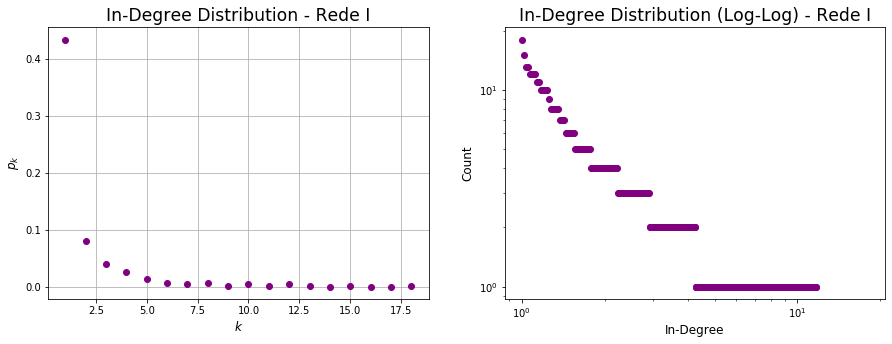

In [532]:
# Distribuição dos graus de entrada
plot_in_degree_distribution(V1,'Rede I')

In [540]:
# O primeiro momento é igual ao grau médio da rede
m1 = momment_of_degree_distribution(V1,1,'in')
vk = list(dict(V1.in_degree()).values())
print("Grau Médio = ", np.mean(vk))
print("Primeiro momento da distribuição de grau = ", m1)
print('\n')

# Variância de <k>
m2 = momment_of_degree_distribution(V1,2,'in')
print("Segundo momento da distribuição de grau = ", m2)
print('\n')
variance = m2 - m1**2
print("Variância de <k> = ", variance)

Grau Médio =  1.19
Primeiro momento da distribuição de grau =  1.19


Segundo momento da distribuição de grau =  4.973999999999999


Variância de <k> =  3.557899999999999


In [534]:
# Grau máximo esperado


In [535]:
# Diâmetro esperado 


#### REDE 2: 
A figura mostra a rede gerada **SF2**, com $\left\langle k\right\rangle = 2$ e $\alpha = 2.5$.
<img src="Figuras/SF2.png" alt="drawing" width="500"/>

In [536]:
# A partir da lista de arestas SF2, podemos construir a rede correspondente
V2 = nx.DiGraph(SF2)
print(nx.info(V2))

Name: 
Type: DiGraph
Number of nodes: 1000
Number of edges: 1651
Average in degree:   1.6510
Average out degree:   1.6510


In [537]:
print('Grau de Entrada Máximo: ' + str(max(list(dict(V2.in_degree()).values()))))
print('Grau de Saída Máximo: ' + str(max(list(dict(V2.out_degree()).values()))))

Grau de Entrada Máximo: 25
Grau de Saída Máximo: 21


In [538]:
print('Diâmetro da rede: ' + str(diameter(V2)))

Diâmetro da rede: 19


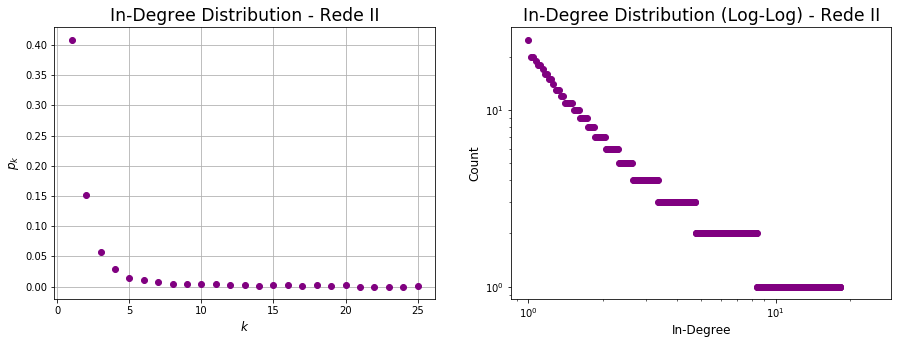

In [539]:
# Distribuição dos graus de entrada
plot_in_degree_distribution(V2,'Rede II')

In [541]:
# O primeiro momento é igual ao grau médio da rede
m1 = momment_of_degree_distribution(V2,1,'in')
vk = list(dict(V2.in_degree()).values())
print("Grau Médio = ", np.mean(vk))
print("Primeiro momento da distribuição de grau = ", m1)
print('\n')

# Variância de <k>
m2 = momment_of_degree_distribution(V2,2,'in')
print("Segundo momento da distribuição de grau = ", m2)
print('\n')
variance = m2 - m1**2
print("Variância de <k> = ", variance)

Grau Médio =  1.651
Primeiro momento da distribuição de grau =  1.651


Segundo momento da distribuição de grau =  9.547


Variância de <k> =  6.821199


In [542]:
# Grau máximo esperado


In [543]:
# Diâmetro esperado 


#### REDE 3: 
A figura mostra a rede gerada **SF3**, com $\left\langle k\right\rangle = 10$ e $\alpha = 2,5$.
<img src="Figuras/SF3.png" alt="drawing" width="500"/>

In [544]:
# A partir da lista de arestas SF3, podemos construir a rede correspondente
V3 = nx.DiGraph(SF3)
print(nx.info(V3))

Name: 
Type: DiGraph
Number of nodes: 1000
Number of edges: 8503
Average in degree:   8.5030
Average out degree:   8.5030


In [545]:
print('Grau de Entrada Máximo: ' + str(max(list(dict(V3.in_degree()).values()))))
print('Grau de Saída Máximo: ' + str(max(list(dict(V3.out_degree()).values()))))

Grau de Entrada Máximo: 56
Grau de Saída Máximo: 56


In [546]:
print('Diâmetro da rede: ' + str(diameter(V3)))

Diâmetro da rede: 8


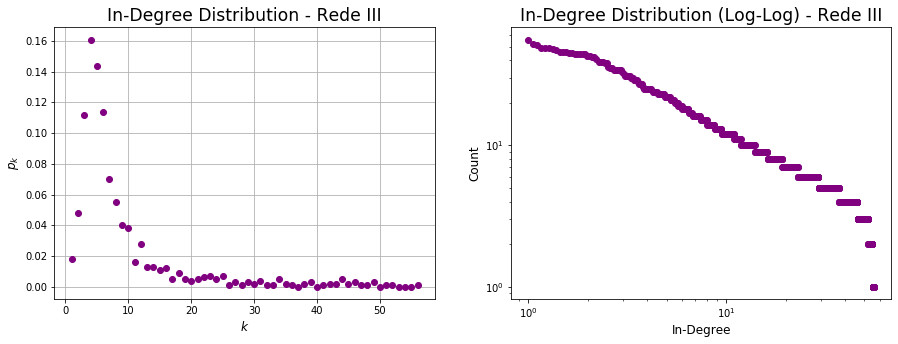

In [566]:
# Distribuição dos graus de entrada
plot_in_degree_distribution(V3,'Rede III')

In [567]:
# O primeiro momento é igual ao grau médio da rede
m1 = momment_of_degree_distribution(V3,1,'in')
vk = list(dict(V3.in_degree()).values())
print("Grau Médio = ", np.mean(vk))
print("Primeiro momento da distribuição de grau = ", m1)
print('\n')

# Variância de <k>
m2 = momment_of_degree_distribution(V3,2,'in')
print("Segundo momento da distribuição de grau = ", m2)
print('\n')
variance = m2 - m1**2
print("Variância de <k> = ", variance)

Grau Médio =  8.503
Primeiro momento da distribuição de grau =  8.502999999999998


Segundo momento da distribuição de grau =  145.62700000000004


Variância de <k> =  73.32599100000007


In [ ]:
# Grau máximo esperado


In [ ]:
# Diâmetro esperado 


A tabela a seguir mostra o resumos das medidas calculadas para cada uma dessas redes apresentadas.

| Redes 	| Arestas 	| Var($\left\langle k\right\rangle$) 	| $k_{in}$ Máximo 	| Diâmetro 	| Componentes Conexas 	|
|:--------:	|---------	|:----------------------------------:	|:---------------:	|:--------:	|:-------------------:	|
| Rede I 	| 1190 	| 3.55 	| 18 	| 19 	| 175 	|
| Rede II 	| 1651 	| 6.82 	| 25 	| 19 	| 75 	|
| Rede III 	| 8503 	| 73.32 	| 56 	| 8 	| 1 	|

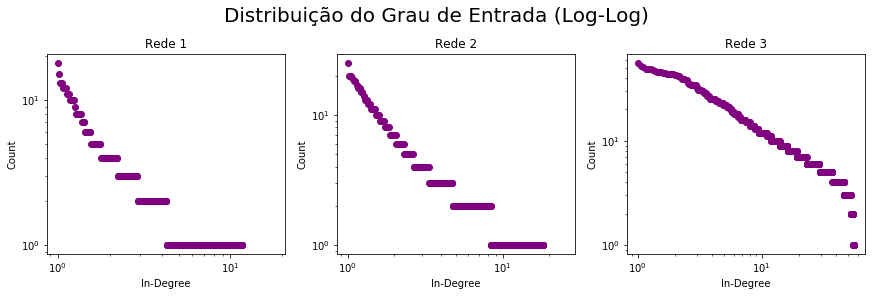

In [606]:
fig, axs = plt.subplots(1,3, figsize=(12, 4), constrained_layout=True)
fig.suptitle('Distribuição do Grau de Entrada (Log-Log)', fontsize=20)
V = [V1, V2 ,V3]
axs = axs.ravel()
for i in range(3):
    degree_sequence=sorted(dict(V[i].in_degree).values(),reverse=True) 
    x = list(np.linspace(1,max(degree_sequence),len(degree_sequence)))
    axs[i].loglog(x, degree_sequence, 'p',  marker='o', color = "purple")
    axs[i].set_title('Rede ' + str(i+1))
    axs[i].set_xlabel('In-Degree')
    axs[i].set_ylabel('Count')

___
## II. Simulação de Epidemias
___

No **modelo SIS**, os indivíduos infectados não são imunes às doenças podendo, mesmo após a recuperação, serem infectados novamente. Há apenas dois estados (modelo compartimental): **suscetíveis** (S) e **infectados** (I), em que esses últimos tornam-se suscetíveis após a recuperação.

Um indivíduo no estado suscetível não possui a doença, mas pode pegá-la caso entre em contato com algum indíviduo no estado infectado, aquele que possui a doença e pode transmití-la (mistura homogênea). Vamos considerar uma doença que se espalha através de uma população de indivíduos. Seja $S(t)$ o número de indivíduos que são suscetíveis no tempo $t$ e $I(t)$ o número de indivíduos que estão infectados. Como nesse modelo um indivíduo só possui duas opções de estados, temos que $S + I = N$, onde $N$ é a população total. O conjunto de equações que descrevem a dinâmica desse modelo é dada pelas seguintes equações diferenciais:

$$\frac{ds}{dt}=\mu i - \beta \left \langle k \right \rangle i(1-i) \qquad \frac{di}{dt}=\beta \left \langle k \right \rangle i(1-i) - \mu i$$


onde $\beta$ é a probabilidade de a doença ser transmitida de um indivíduo infectado para um indivíduo suscetível (aqueles que são seus vizinhos) em um tempo unitário (**taxa de infecção**) e $\mu$ é a probabilidade de um indivíduo infectado se recuperar da doença em um tempo unitário (**taxa de recuperação**).

O algoritmo descrito na função `SIS`, a seguir, simula o comportamento epidêmico de uma rede no modelo SIS.

In [630]:
def SIS(G, beta, mu, time):
    
    N = len(G.nodes())
    nx.set_node_attributes(G, {i: False for i in range(1,N+1)}, 'infectado')
 
    nodes_infected = rnd.sample(range(1,N+1), 5) # Em t0 temos 5 infectados
     
    for node in nodes_infected:
        G.node[node]['infectado'] = True
     
    historic = [len(nodes_infected)] # Aramzena a quantidade de infectados conforme a evolução do tempo
    
    for t in range(1,time+1):
        
        old_infected = nodes_infected
        nodes_infected = []
 
        for node in old_infected:
            for neighbor in G.neighbors(node): # Para cada vizinho do nó infectado
                
                # Nós que não estão infectados 
                if G.node[neighbor]['infectado'] == False:
                    if rnd.random() < beta: # Se o aleatório for menor que a taxa de infecção
                        nodes_infected.append(neighbor)
                        G.node[neighbor]['infectado'] = True # o vizinho torna-se infectado
            
            # Nós que estão infectados
            if rnd.random() < mu: # Se o aleatório for menor que a taxa de recuperação,
                G.node[node]['infectado'] = False # o nó infectado torna-se suscetível
            else:
                nodes_infected.append(node) # o nó infectado permanece infectado
                
        historic.append(len(nodes_infected))
        
    return (G, historic)

___
### EXERCÍCIO 1:

Gere uma rede aleatória com $10.000$ vértices e grau médio $\left \langle k \right \rangle = 20$. Comece com 5 vértices aleatórios infectados e simule a propagação da infecção pelo **modelo SIS** com os parâmetros abaixo e compare com os resultados esperados.

a. $\beta=0.02$ e $\mu=0.1$

b. $\beta=0.02$ e $\mu=0.4$

c. $\beta=0.02$ e $\mu=0.5$
    
Mostre que se $𝑅_0 = \frac{\beta \left \langle k \right \rangle}{\mu} > 1$ então a doença se fixa na rede, no modelo SIS de campo médio.
___

In [619]:
def RandomGraph(N, k):
    pk = k/(N-1)
    G = []
 
    nodes = range(1,N+1)
    edges = itertools.combinations(nodes,2)
    for e in edges:
        if rnd.random() < pk:
            G.append(list(e))
    return G

In [700]:
N = 10000
G = nx.Graph()
G.add_edges_from(RandomGraph(N, 20))

In [684]:
beta = 0.02
time = 300
G1,T1 = SIS(G, beta, 0.1, time)
G2,T2 = SIS(G, beta, 0.4, time)
G3,T3 = SIS(G, beta, 0.5, time)

pickle.dump([G,G1,T1,G2,T2,G3,T3], open("Redes/SIS_Random.p", "wb"))
#[G,G1,T1,G2,T2,G3,T3] = pickle.load(open("Redes/SIS_Random.p", "rb" ))

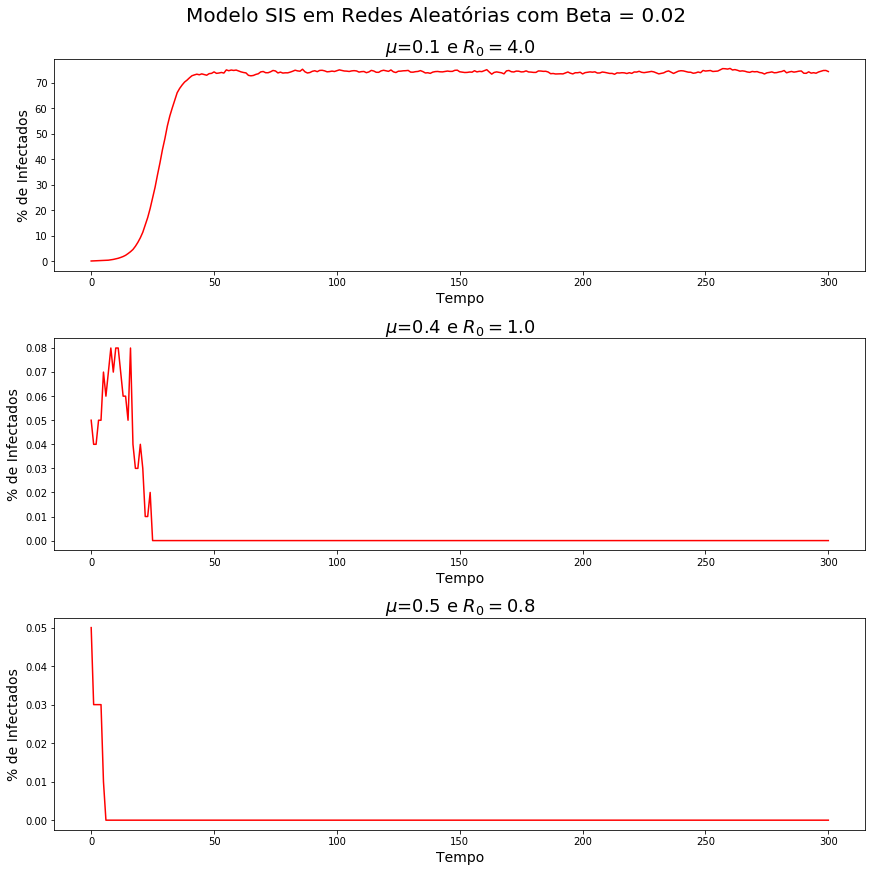

In [708]:
fig, axs = plt.subplots(3,1, figsize=(12, 12), constrained_layout=True)
fig.suptitle('Modelo SIS em Redes Aleatórias com Beta = 0.02', fontsize=20)
T = [T1,T2,T3]
mu = [0.1,0.4,0.5]
#axs = axs.ravel()
for i in range(3):
    ro = beta*20/mu[i]
    axs[i].plot([j/N*100 for j in T[i]], color = "red")
    axs[i].set_title("$\mu$=" + str(mu[i]) + ' e $R_0=$' + str(ro), fontsize=18)
    axs[i].set_xlabel('Tempo', fontsize=14)
    axs[i].set_ylabel('% de Infectados', fontsize=14)

Uma forma muito comum de classi􏰀cação dos resultados obtidos por essas simulações é por meio de uma quantidade limite que determina se uma epidemia ocorre ou se a doença simplesmente morre. Essa quantidade é denominada o **número de reprodução básico** ($R$0) e é responsável por mensurar o potencial de transmissão de uma doença.

$$R_0=\frac{\beta \left \langle k \right \rangle}{\mu}$$

Se $R_0 > 1$, então estamos no **estado endêmico** e se $R_0 < 1$, estamos no **estado livre de doença**, em que a doença morre.

Quando $\mu = 0,1$ (**simulação 1**) temos que $R_0 = 4 > 1$ e, portanto, estamos no **estado endêmico** (ou estacionário). Ou seja, para uma baixa taxa de recuperação, o grá􏰀co de simulação segue uma curva logística. Apesar de nem todo mundo fi􏰀car infectado, $i(t)$ quanto $t \rightarrow \infty$ atinge um valor constante menor do que 1. Dessa forma, a qualquer momento, apenas uma fração 􏰀finita da população está infectada.


Quando $\mu = 0,5$ (**simulação 3**) temos que $R_0 = 08 < 1$ e, portanto, estamos no **estado livre de doença**. Ou seja, para uma taxa de recuperação muito grande ($\mu > \beta$), a cada unidade de tempo $t$, o número de indivíduos suscetíveis excede o número de indivíduos recém-infectados, indicando que a infeção inicial vai morrer com o tempo de forma exponencial. 

Quando $\mu = 0,4$ (**simulação 2**) temos que $R_0 = 1 < 1$ e estamos em um ponto crítico em que há a mudança de estado. Nesse ponto cada vez que realizamos a simulação obtemos um comportamento inicial bem diferente, no entanto, sempre indica que a infeção inicial irá morrer com o tempo.

Os resultados obtidos com as simulações para as redes aleatórias ocorreram como esperado. No entanto, dependendo da distribuição dos graus, o espalahamento da infecção se comporta de forma diferente apesar dos valores de R0. Veremos isso a seguir, em que fazemos uma simulação para redes livre de escala.

___
### EXERCÍCIO 2:

Gere uma rede livre de escala com $10.000$ vértices, grau médio $\left \langle k \right \rangle > 20$ e expoente $\alpha$ entre 2 e 3. Comece com 5 vértices aleatórios infectados e simule a propagação da infecção pelo **modelo SIS** com os parâmetros abaixo e compare com os resultados esperados.

a. $\beta=0.01$ e $\mu=0.1$

b. $\beta=0.01$ e $\mu=0.2$ 

c. $\beta=0.01$ e $\mu=0.3$ 
___

___
### EXERCÍCIO 3:

Considere o exercício anterior, **letra a**. Descubra o número de vértices imunizados necessários para impedir o estado endêmico nos seguintes cenários:

a. Os vértices imunizados são escolhidos aleatoriamente.

b. Os vértices imunizados são os de maior grau (hubs).

c. Os vértices imunizados são os vizinhos de vértices escolhidos aleatoriamente.
___